In [3]:
import cptac
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics
import parse_correlations_dataframe as get_corr
import copy

In [17]:
def find_mutation_corr_effect(cancer_type, gene, corr_dif = True):
    gene_multi = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene, 'somatic_mutation': gene})
    
    if gene_multi[str(gene + '_proteomics')].isnull().values.any():
        return float("NaN"), float("NaN"), float("NaN")    
    trans = list(gene_multi[str(gene +"_transcriptomics")])
    prot = list(gene_multi[str(gene + '_proteomics')])
    group = []
    for i in gene_multi[str(gene + '_Mutation_Status')]:
        if type(i) == str:
            group.append("mutation")
        else:
            group.append("wt")           
    gene_df = pd.DataFrame({'Type': group, 'Proteomics': prot, 'Transcriptomics': trans})
    is_mut = gene_df['Type'] == 'mutation'
    is_wt = gene_df['Type'] == 'wt'
    gene_df = gene_df.dropna()
    if len(gene_df[is_mut]['Proteomics']) < 2 or len(gene_df[is_mut]['Transcriptomics']) < 2 or len(gene_df[is_wt]['Proteomics']) < 2 or len(gene_df[is_wt]['Transcriptomics']) < 2:
        return float("NaN"), float("NaN"), float("NaN")
    gene_cor, gen_pval = scipy.stats.pearsonr(gene_df[is_mut]['Proteomics'], gene_df[is_mut]['Transcriptomics'])
    wt_cor, wt_pval = scipy.stats.pearsonr(gene_df[is_wt]['Proteomics'], gene_df[is_wt]['Transcriptomics'])
    gene_m, gene_b, gene_r, gene_p, gene_se = stats.linregress(gene_df[is_mut]['Proteomics'], gene_df[is_mut]['Transcriptomics'])
    wt_m, wt_b, wt_r, wt_p, wt_se = stats.linregress(gene_df[is_wt]['Proteomics'], gene_df[is_wt]['Transcriptomics'])
    gene_r2 = gene_r ** 2
    wt_r2 = wt_r ** 2
    r2_delta = gene_r2 - wt_r2
    corr_dif = gene_cor - wt_cor
    if corr_dif:
        return abs(corr_dif), r2_delta, gene_df
    else: 
        return gene_cor, wt_cor, gene_df
    

In [6]:
def find_norm_tumor_corr_effect(cancer_type, gene):
    tumor = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene}, tissue_type= 'tumor', flatten = True)
    normal = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene}, tissue_type= 'normal', flatten = True)
    tumor = tumor.dropna()
    normal = normal.dropna()
    if len(normal) < 2 or len(tumor) < 2:
        return float("NaN"), float("NaN"), float("NaN")
    tumor.columns = ['proteomics', 'transcriptomics']
    normal.columns = ['proteomics', 'transcriptomics']
    groups = ['tumor'] * len(tumor)
    groups.extend(['normal']*len(normal))
    prot_list = list(tumor['proteomics'])
    prot_list.extend(list(normal['proteomics']))
    trans_list = list(tumor['transcriptomics'])
    trans_list.extend(list(normal['transcriptomics']))
    gene_df = pd.DataFrame({'Type': groups, 'Proteomics': prot_list, 'Transcriptomics': trans_list})
    is_tum = gene_df['Type'] == 'tumor'
    is_norm = gene_df['Type'] == 'normal'
    tum_cor, tum_pval = scipy.stats.pearsonr(gene_df[is_tum]['Proteomics'], gene_df[is_tum]['Transcriptomics'])
    norm_cor, norm_pval = scipy.stats.pearsonr(gene_df[is_norm]['Proteomics'], gene_df[is_norm]['Transcriptomics'])
    return tum_cor, norm_cor, gene_df
        
        
    

In [7]:
def get_cancer_string(cancer):
    if cancer == brca:
        return "brca"
    if cancer == ccrcc:
        return "ccrcc"
    if cancer == colon:
        return 'colon'
    if cancer == en:
        return 'en'
    if cancer == gbm:
        return 'gbm'
    if cancer == luad:
        return 'luad'
    if cancer == ovarian:
        return 'ovarian'
    if cancer == hnscc:
        return 'hnscc'
    if cancer == lscc:
        return 'lscc'

In [8]:
brca = cptac.Brca()
ccrcc = cptac.Ccrcc()
colon = cptac.Colon()
en = cptac.Endometrial()
gbm = cptac.Gbm()
luad = cptac.Luad()
ovarian = cptac.Ovarian()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (<ipython-input-8-0467c23f8dc0>, line 5)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-8-0467c23f8dc0>, line 8)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-8-0467c23f8dc0>, line 9)


In [9]:
cancer_genes = ['TP53','BRCA2','KMT2D','KRAS','PIK3CA','PTEN']
cancer_list = [ccrcc,en,luad,hnscc,lscc]

In [10]:
tum_corr = []
norm_corr = []
gene_dfs = []
genes = []
cancer_type = []
for cancer in cancer_list:
    for gene in cancer_genes:
        if gene == "KRAS" and cancer == ccrcc:
            continue
        tum_cor, norm_cor, gene_df = find_norm_tumor_corr_effect(cancer, gene)
        if not np.isnan(tum_cor):
            tum_corr.append(tum_cor)
            norm_corr.append(norm_cor)
            gene_dfs.append(gene_df)
            cancer_type.append(get_cancer_string(cancer))
            genes.append(gene)
norm_tumor_effects = pd.DataFrame({'cancer': cancer_type, 'gene': genes, 'tumor_correlation': tum_corr, 'normal_correlation': norm_corr, 'gene_df': gene_dfs})
norm_tumor_effects.head()
        
        
        
        
        

cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: BRCA2 (<ipython-input-6-4eb76cdc6c64>, line 2)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: BRCA2 (<ipython-input-6-4eb76cdc6c64>, line 3)
cptac warning: You tried to flat

,cancer,gene,tumor_correlation,normal_correlation,gene_df
0,ccrcc,TP53,0.146573,-0.278706,Type Proteomics Transcriptomics 0 t...
1,ccrcc,BRCA2,-0.341958,-0.662538,Type Proteomics Transcriptomics 0 t...
2,ccrcc,KMT2D,0.078602,-0.071417,Type Proteomics Transcriptomics 0 ...
3,ccrcc,PIK3CA,0.521751,0.199898,Type Proteomics Transcriptomics 0 ...
4,ccrcc,PTEN,0.497284,0.649130,Type Proteomics Transcriptomics 0 ...


In [11]:
norm_tumor_effects = norm_tumor_effects.assign(cor_dif = abs(norm_tumor_effects['tumor_correlation'] - norm_tumor_effects['normal_correlation']))

In [12]:
norm_tumor_effects.head()

,cancer,gene,tumor_correlation,normal_correlation,gene_df,cor_dif
0,ccrcc,TP53,0.146573,-0.278706,Type Proteomics Transcriptomics 0 t...,0.425279
1,ccrcc,BRCA2,-0.341958,-0.662538,Type Proteomics Transcriptomics 0 t...,0.320580
2,ccrcc,KMT2D,0.078602,-0.071417,Type Proteomics Transcriptomics 0 ...,0.150018
3,ccrcc,PIK3CA,0.521751,0.199898,Type Proteomics Transcriptomics 0 ...,0.321853
4,ccrcc,PTEN,0.497284,0.649130,Type Proteomics Transcriptomics 0 ...,0.151846


In [13]:
norm_tumor_effects = norm_tumor_effects.sort_values(by = 'cor_dif', ascending=False, ignore_index=True)
norm_tumor_effects.head()

,cancer,gene,tumor_correlation,normal_correlation,gene_df,cor_dif
0,lscc,TP53,0.723227,-0.344411,Type Proteomics Transcriptomics 0 ...,1.067638
1,hnscc,PIK3CA,0.814412,0.028087,Type Proteomics Transcriptomics 0 ...,0.786325
2,hnscc,PTEN,0.636979,-0.073318,Type Proteomics Transcriptomics 0 ...,0.710297
3,luad,TP53,0.496929,-0.193213,Type Proteomics Transcriptomics 0 ...,0.690142
4,lscc,PTEN,0.695318,0.054532,Type Proteomics Transcriptomics 0 ...,0.640787


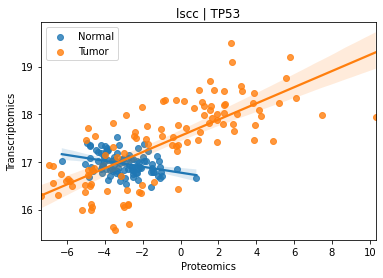

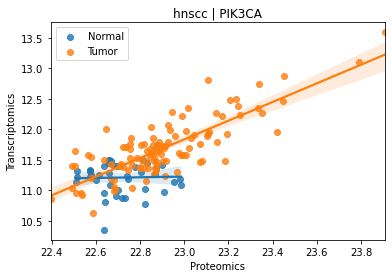

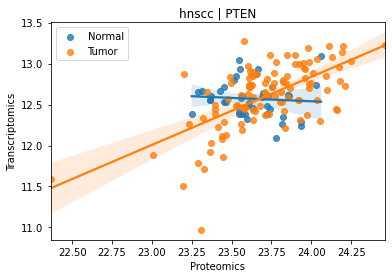

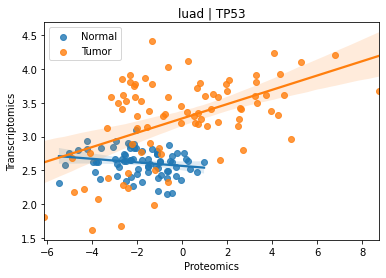

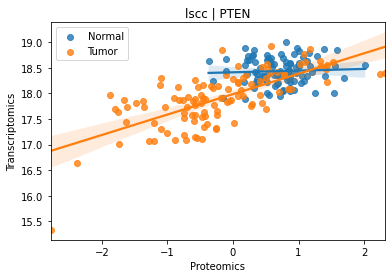

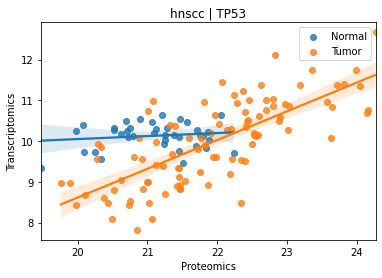

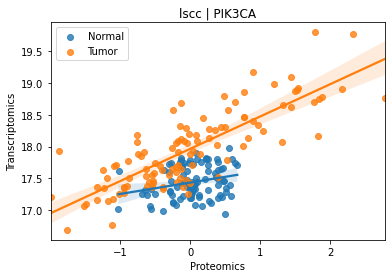

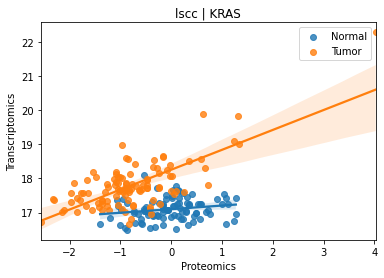

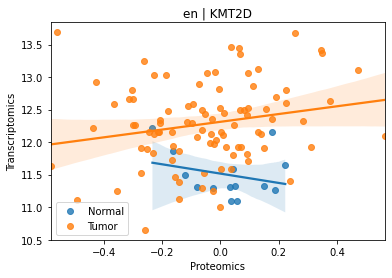

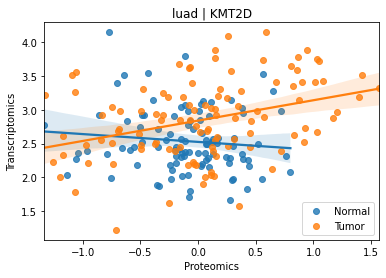

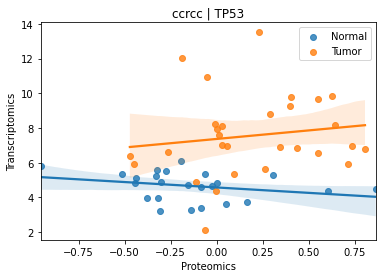

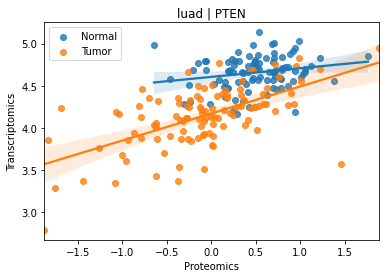

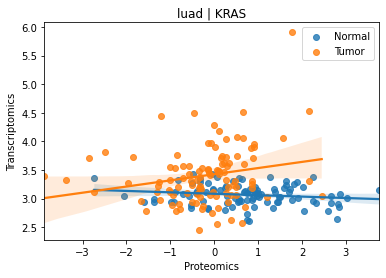

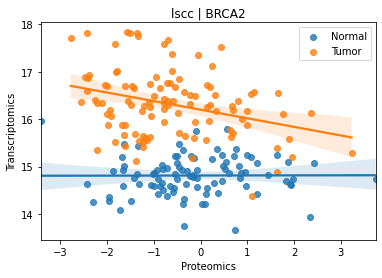

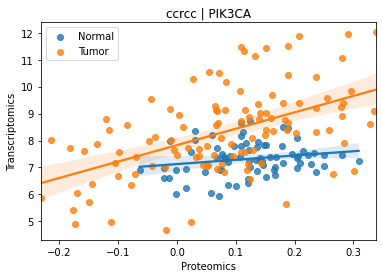

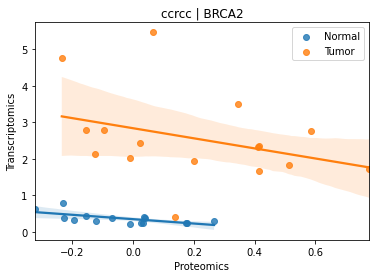

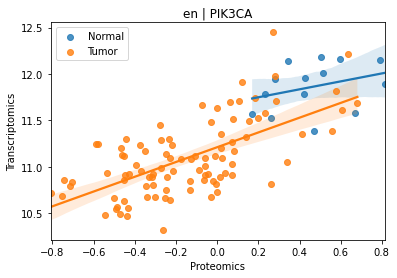

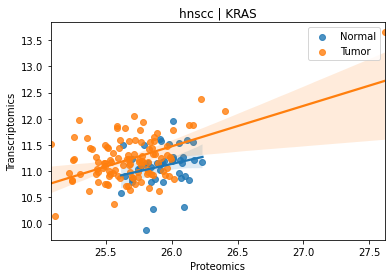

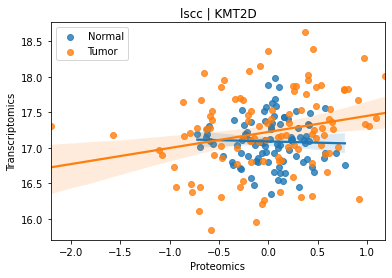

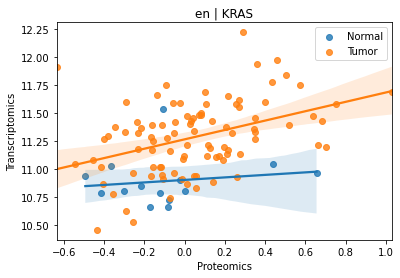

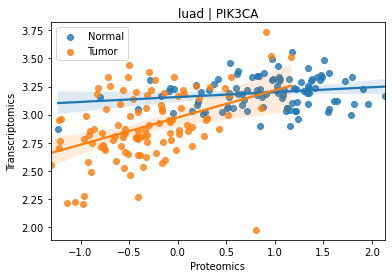

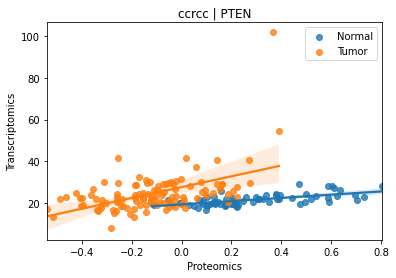

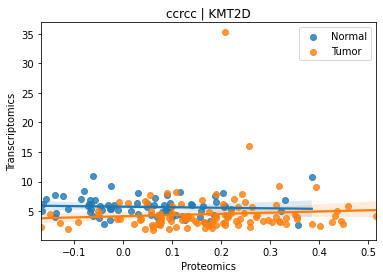

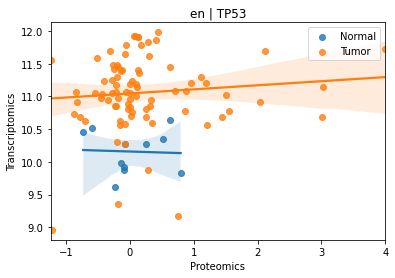

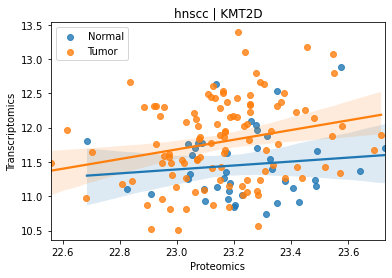

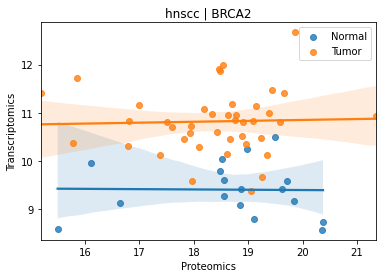

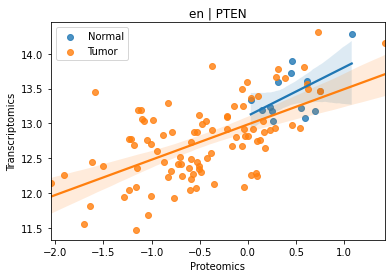

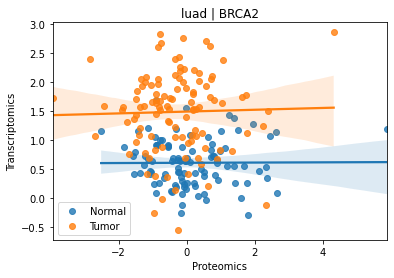

<Figure size 432x288 with 0 Axes>

In [15]:
for index, df in enumerate(norm_tumor_effects['gene_df']):
    is_norm = df['Type']=='normal'
    is_tum = df['Type'] == 'tumor'
    ax = sns.regplot(x = 'Proteomics', y = 'Transcriptomics', data = df[is_norm], label = "Normal")
    ax = sns.regplot(x = 'Proteomics', y = 'Transcriptomics', data = df[is_tum], label = 'Tumor')
    ax.legend(loc = 'best')
    plt.title(str(norm_tumor_effects['cancer'][index] + ' | ' + norm_tumor_effects['gene'][index]))
    plt.show()
    plt.savefig('Normal_vs_tumor_gene_correlation_plots/' + str(norm_tumor_effects['cancer'][index] + '_' + norm_tumor_effects['gene'][index] + '.png'))

In [14]:
#focus on kras and pten

In [15]:
dfs = []
for cancer in cancer_list:
    for gene in cancer_genes:
        if gene == "KRAS" and cancer == ccrcc:
            continue
        tum_cor, norm_cor, gene_df = find_norm_tumor_corr_effect(cancer, gene)
        if not np.isnan(tum_cor):
            gene_df['cancer'] = [get_cancer_string(cancer)]*len(gene_df)
            gene_df['gene'] = [gene]*len(gene_df)
            dfs.append(gene_df)
dfs.head()
        
        
        

cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 697)
cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: BRCA2 (<ipython-input-3-4eb76cdc6c64>, line 2)
cptac warning: You tried t

[       Type  Proteomics  Transcriptomics cancer  gene
0     tumor    0.235538        21.616591  ccrcc  BRAF
1     tumor    0.232718        19.209432  ccrcc  BRAF
2     tumor    0.034752        14.278585  ccrcc  BRAF
3     tumor    0.328557        22.972120  ccrcc  BRAF
4     tumor    0.136153        15.809168  ccrcc  BRAF
..      ...         ...              ...    ...   ...
180  normal   -0.006068        20.481532  ccrcc  BRAF
181  normal    0.009571        19.272746  ccrcc  BRAF
182  normal   -0.069232        19.506177  ccrcc  BRAF
183  normal   -0.015187        19.897661  ccrcc  BRAF
184  normal   -0.104049        20.944983  ccrcc  BRAF

[185 rows x 5 columns],       Type  Proteomics  Transcriptomics cancer  gene
0    tumor    0.402191         9.780815  ccrcc  TP53
1    tumor    0.092737         5.350098  ccrcc  TP53
2    tumor    0.288820         8.795810  ccrcc  TP53
3    tumor    0.346025         6.911960  ccrcc  TP53
4    tumor   -0.265361         6.610207  ccrcc  TP53
5    tum

In [18]:
corr_diffs = []
r2_deltas = []
filtered_genes = []
gene_dfs = []
for gene in cancer_genes:
    
    cor, r2, gene_df = find_mutation_corr_effect(en, gene)
    if not np.isnan(cor):
        corr_diffs.append(cor)
        r2_deltas.append(r2)
        filtered_genes.append(gene)
        gene_dfs.append(gene_df)
en_mutation_effects = pd.DataFrame({'gene': filtered_genes, 'correlation_difference': corr_diffs, "r2_delta" : r2_deltas, "gene_dataframes": gene_dfs})
en_mutation_effects.head()

cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: BRCA2 (<ipython-input-17-c5b7e66650ec>, line 2)
<ipython-input-17-c5b7e66650ec>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(gene_df[is_mut]['Proteomics']) < 2 or len(gene_df[is_mut]['Transcriptomics']) < 2 or len(gene_df[is_wt]['Proteomics']) < 2 or len(gene_df[is_wt]['Transcriptomics']) < 2:
<ipython-input-17-c5b7e66650ec>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gene_cor, gen_pval = scipy.stats.pearsonr(gene_df[is_mut]['Proteomics'], gene_df[is_mut]['Transcriptomics'])
<ipython-input-17-c5b7e66650ec>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wt_cor, wt_pval = scipy.stats.pearsonr(gene_df[is_wt]['Proteomics'], gene_df[is_wt]['Transcriptomics'])
<ipython-input-17-c5b7e66650ec>:22: UserWarning: Boolean Series key will be r

,gene,correlation_difference,r2_delta,gene_dataframes
0,KMT2D,0.634663,0.136340,Type Proteomics Transcriptomics 0 ...
1,KRAS,0.307777,0.276435,Type Proteomics Transcriptomics 0 ...
2,PIK3CA,0.199724,-0.269978,Type Proteomics Transcriptomics 0 ...
3,PTEN,0.177640,-0.256279,Type Proteomics Transcriptomics 0 ...
